In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time # To measure training time

# Scikit-learn and Imblearn (CPU)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression # Renamed import alias
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler


# --- Configuration ---
# Define file paths for your datasets
# !! Update these paths to where your files are located !!
TRAIN_CSV_PATH = 'exoTrain.csv'
TEST_CSV_PATH = 'exoTest.csv'
RANDOM_STATE = 42 # for reproducibility

# --- Data Loading ---
def load_data(train_path, test_path):
    """Loads training and testing data from CSV files."""
    try:
        print(f"Loading training data from: {train_path}")
        df_train = pd.read_csv(train_path)
        print(f"Loading testing data from: {test_path}")
        df_test = pd.read_csv(test_path)
        print("Data loaded successfully.")
        return df_train, df_test
    except FileNotFoundError:
        print(f"Error: One or both files not found. Please check paths:")
        print(f"- Train path: {train_path}")
        print(f"- Test path: {test_path}")
        return None, None
    except Exception as e:
        print(f"An error occurred during data loading: {e}")
        return None, None

# --- Data Preprocessing (CPU) ---
def preprocess_and_scale_cpu(df_train, df_test):
    """Separates features/labels, scales labels, scales features (CPU), returns numpy arrays."""
    print("Preprocessing data (CPU steps)...")
    # Separate features (X) and labels (y)
    X_train_raw = df_train.drop('LABEL', axis=1)
    y_train_raw = df_train['LABEL']
    X_test_raw = df_test.drop('LABEL', axis=1)
    y_test_raw = df_test['LABEL']

    # Convert labels: 1 (no exoplanet) -> 0, 2 (exoplanet) -> 1
    y_train = (y_train_raw - 1).astype(int).values # Get as numpy array
    y_test = (y_test_raw - 1).astype(int).values # Get as numpy array

    print(f"Original training set shape: {X_train_raw.shape}")
    print(f"Original test set shape: {X_test_raw.shape}")
    print(f"Training labels distribution:\n{pd.Series(y_train).value_counts()}")
    print(f"Test labels distribution:\n{pd.Series(y_test).value_counts()}")

    # Scale features using StandardScaler (CPU)
    print("Scaling features using StandardScaler (CPU)...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_raw.values)
    X_test_scaled = scaler.transform(X_test_raw.values)

    print("CPU Preprocessing and Scaling complete.")
    # Return scaler for potential inverse transform, and scaled data + labels
    return scaler, X_train_scaled, y_train, X_test_scaled, y_test

# --- Oversampling (CPU) ---
def oversample_cpu(X_train_scaled, y_train):
    """Performs oversampling on the training data (CPU)."""
    print("Oversampling training data using RandomOverSampler (CPU)...")
    oversampler = RandomOverSampler(sampling_strategy='auto', random_state=RANDOM_STATE)
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_scaled, y_train)
    print(f"Training data shape after oversampling: {X_train_resampled.shape}")
    print(f"Training labels distribution after oversampling:\n{pd.Series(y_train_resampled).value_counts()}")
    return X_train_resampled, y_train_resampled

# --- Model Training (CPU) ---
def train_logistic_regression(X_train_processed, y_train_processed):
    """Trains a Logistic Regression model on the CPU using scikit-learn."""
    print("Training Logistic Regression model (CPU - scikit-learn)...")
    model = LogisticRegression(max_iter=1000,
                               random_state=RANDOM_STATE,
                               solver='liblinear', # Good default for CPU
                               C=1.0,
                               penalty='l2',
                               fit_intercept=True,
                               tol=1e-4)
    start_time = time.time()
    model.fit(X_train_processed, y_train_processed)
    end_time = time.time()
    print(f"CPU Training completed in {end_time - start_time:.2f} seconds.")

    return model

# --- Model Evaluation (CPU) ---
def evaluate_model(model, X_test_scaled, y_test, model_name="Model"):
    """Evaluates the model on the test set and prints metrics."""
    print(f"\n--- Evaluating {model_name} ---")
    y_pred = None
    y_pred_proba = None

    try:
        print("Predicting on test data (CPU)...")
        start_time = time.time()
        # Use scikit-learn's predict method
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        end_time = time.time()
        print(f"CPU Prediction completed in {end_time - start_time:.2f} seconds.")

        # Ensure predictions are integers if they aren't already
        y_pred = y_pred.astype(int)

        # Get model classes
        try:
             model_classes = model.classes_
        except AttributeError:
             # If .classes_ doesn't exist (shouldn't happen for LogReg), assume [0, 1]
             print("Warning: Could not get model.classes_, assuming [0, 1]")
             model_classes = np.array([0, 1])


        # Print Classification Report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=["NO exoplanet (0)", "YES exoplanet (1)"], labels=model_classes))

        # Plot Confusion Matrix
        print("\nConfusion Matrix:")
        cm = confusion_matrix(y_test, y_pred, labels=model_classes)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NO exoplanet (0)", "YES exoplanet (1)"])

        fig, ax = plt.subplots(figsize=(6, 6))
        disp.plot(ax=ax, cmap='Blues', values_format='d')
        ax.set_title(f'{model_name} Confusion Matrix')
        plt.tight_layout()
        plt.show()

    except Exception as e: # Catch any standard errors during evaluation
        print(f"An unexpected error occurred during evaluation: {e}")


# --- Main Execution ---
if __name__ == "__main__":
    print("Starting Exoplanet Detection Baseline Script (CPU Only)...")

    # 1. Load Data
    df_train, df_test = load_data(TRAIN_CSV_PATH, TEST_CSV_PATH)

    if df_train is not None and df_test is not None:
        # 2. Preprocess Data (CPU Scaling)
        scaler, X_train_scaled, y_train, X_test_scaled, y_test = preprocess_and_scale_cpu(df_train, df_test)

        # 3. Oversample Training Data (CPU)
        X_train_resampled, y_train_resampled = oversample_cpu(X_train_scaled, y_train)

        # 4. Train Logistic Regression Model (CPU)
        # Pass the resampled training data
        log_reg_model = train_logistic_regression(X_train_resampled, y_train_resampled)

        # 5. Evaluate Model (CPU)
        # Pass the original scaled test data (not resampled)
        evaluate_model(log_reg_model, X_test_scaled, y_test,
                       model_name="Logistic Regression")

        print("\nScript finished.")
    else:
        print("\nScript aborted due to data loading errors.")

Starting Exoplanet Detection Baseline Script (CPU Only)...
Loading training data from: exoTrain.csv
Loading testing data from: exoTest.csv
Data loaded successfully.
Preprocessing data (CPU steps)...
Original training set shape: (5087, 3197)
Original test set shape: (570, 3197)
Training labels distribution:
0    5050
1      37
Name: count, dtype: int64
Test labels distribution:
0    565
1      5
Name: count, dtype: int64
Scaling features using StandardScaler (CPU)...
CPU Preprocessing and Scaling complete.
Oversampling training data using RandomOverSampler (CPU)...
Training data shape after oversampling: (10100, 3197)
Training labels distribution after oversampling:
1    5050
0    5050
Name: count, dtype: int64
Training Logistic Regression model (CPU - scikit-learn)...


Starting Exoplanet Detection Baseline Script (Optimized)...
Loading training data from: exoTrain.csv
Loading testing data from: exoTest.csv
Data loaded successfully.
Preprocessing data (CPU steps)...
Original training set shape: (5087, 3197)
Original test set shape: (570, 3197)
Applying PCA to reduce feature dimensions...
Training set shape after PCA: (5087, 100)
Test set shape after PCA: (570, 100)
Oversampling training data...
Training data shape after oversampling: (10100, 100)
Training Logistic Regression model (CPU)...
convergence after 28 epochs took 3 seconds
Training completed in 2.98 seconds.

--- Evaluating Logistic Regression with PCA ---
Prediction completed in 0.00 seconds.

Classification Report:
                   precision    recall  f1-score   support

 NO exoplanet (0)       0.93      0.02      0.05       565
YES exoplanet (1)       0.01      0.80      0.01         5

         accuracy                           0.03       570
        macro avg       0.47      0.41    

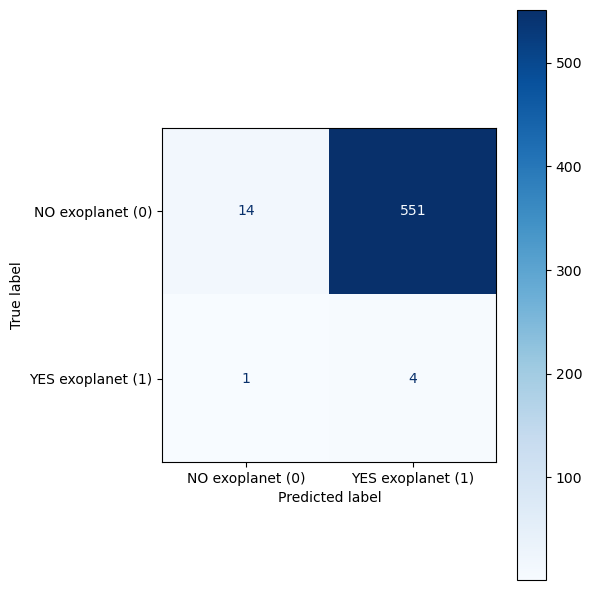


Script finished.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA  # NEW: For dimensionality reduction
from imblearn.over_sampling import RandomOverSampler

# --- Configuration ---
TRAIN_CSV_PATH = 'exoTrain.csv'
TEST_CSV_PATH = 'exoTest.csv'
RANDOM_STATE = 42

# --- Data Loading ---
def load_data(train_path, test_path):
    print(f"Loading training data from: {train_path}")
    df_train = pd.read_csv(train_path)
    print(f"Loading testing data from: {test_path}")
    df_test = pd.read_csv(test_path)
    print("Data loaded successfully.")
    return df_train, df_test

# --- Data Preprocessing (CPU) ---
def preprocess_and_scale_cpu(df_train, df_test):
    print("Preprocessing data (CPU steps)...")
    X_train_raw = df_train.drop('LABEL', axis=1)
    y_train_raw = df_train['LABEL']
    X_test_raw = df_test.drop('LABEL', axis=1)
    y_test_raw = df_test['LABEL']

    y_train = (y_train_raw - 1).astype(int).values
    y_test = (y_test_raw - 1).astype(int).values

    print(f"Original training set shape: {X_train_raw.shape}")
    print(f"Original test set shape: {X_test_raw.shape}")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_raw.values)
    X_test_scaled = scaler.transform(X_test_raw.values)

    # NEW: Apply PCA to reduce dimensions
    print("Applying PCA to reduce feature dimensions...")
    pca = PCA(n_components=100, random_state=RANDOM_STATE)  # Reduce to 100 features
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    print(f"Training set shape after PCA: {X_train_pca.shape}")
    print(f"Test set shape after PCA: {X_test_pca.shape}")

    return scaler, X_train_pca, y_train, X_test_pca, y_test

# --- Oversampling (CPU) ---
def oversample_cpu(X_train_pca, y_train):
    print("Oversampling training data...")
    oversampler = RandomOverSampler(sampling_strategy='auto', random_state=RANDOM_STATE)
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_pca, y_train)
    print(f"Training data shape after oversampling: {X_train_resampled.shape}")
    return X_train_resampled, y_train_resampled

# --- Model Training (CPU) ---
def train_logistic_regression(X_train_processed, y_train_processed):
    print("Training Logistic Regression model (CPU)...")
    model = LogisticRegression(
        solver='saga',  # NEW: Faster solver for large datasets
        max_iter=500,   # NEW: Reduced iterations
        tol=1e-2,       # NEW: Higher tolerance for faster convergence
        random_state=RANDOM_STATE,
        verbose=1       # NEW: Show training progress
    )
    start_time = time.time()
    model.fit(X_train_processed, y_train_processed)
    end_time = time.time()
    print(f"Training completed in {end_time - start_time:.2f} seconds.")
    return model

# --- Model Evaluation (CPU) ---
def evaluate_model(model, X_test_pca, y_test, model_name="Model"):
    print(f"\n--- Evaluating {model_name} ---")
    start_time = time.time()
    y_pred = model.predict(X_test_pca)
    y_pred_proba = model.predict_proba(X_test_pca)[:, 1]
    end_time = time.time()
    print(f"Prediction completed in {end_time - start_time:.2f} seconds.")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=["NO exoplanet (0)", "YES exoplanet (1)"]))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NO exoplanet (0)", "YES exoplanet (1)"])
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.tight_layout()
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    print("Starting Exoplanet Detection Baseline Script (Optimized)...")
    df_train, df_test = load_data(TRAIN_CSV_PATH, TEST_CSV_PATH)

    if df_train is not None and df_test is not None:
        scaler, X_train_pca, y_train, X_test_pca, y_test = preprocess_and_scale_cpu(df_train, df_test)
        X_train_resampled, y_train_resampled = oversample_cpu(X_train_pca, y_train)
        log_reg_model = train_logistic_regression(X_train_resampled, y_train_resampled)
        evaluate_model(log_reg_model, X_test_pca, y_test, model_name="Logistic Regression with PCA")
        print("\nScript finished.")
    else:
        print("\nScript aborted due to data loading errors.")

Starting Exoplanet Detection Script (LogReg, SVC, DT with PCA)...
Loading training data from: exoTrain.csv
Loading testing data from: exoTest.csv
Data loaded successfully.
Preprocessing data (CPU steps)...
Original training set shape: (5087, 3197)
Original test set shape: (570, 3197)
Training labels distribution:
0    5050
1      37
Name: count, dtype: int64
Test labels distribution:
0    565
1      5
Name: count, dtype: int64
Scaling features using StandardScaler (CPU)...
Applying PCA to reduce feature dimensions to 100...
Explained variance ratio by 100 components: 0.9998
Training set shape after PCA: (5087, 100)
Test set shape after PCA: (570, 100)
CPU Preprocessing, Scaling, and PCA complete.
Oversampling training data using RandomOverSampler (CPU)...
Training data shape after oversampling: (10100, 100)
Training labels distribution after oversampling:
1    5050
0    5050
Name: count, dtype: int64

--- Training Logistic Regression ---
Training Logistic Regression model (CPU - scikit

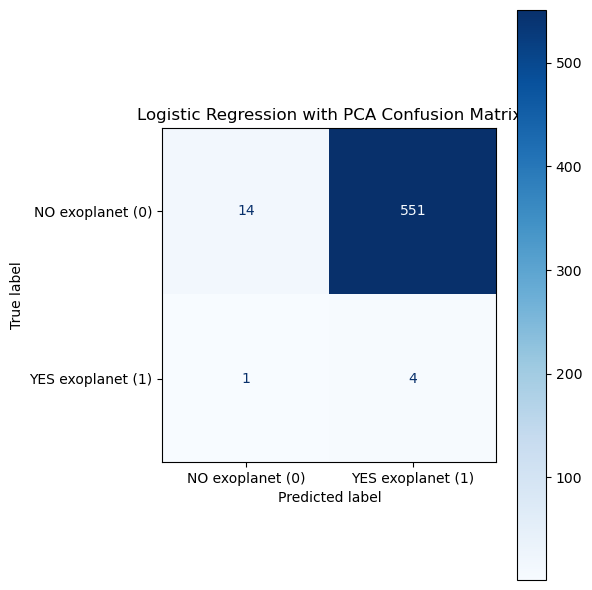


--- Training Support Vector Classifier (SVC) ---
Training SVC model (CPU - scikit-learn)...
SVC Training completed in 48.00 seconds.

--- Evaluating Support Vector Classifier (SVC) with PCA ---
Predicting on test data (CPU)...
CPU Prediction completed in 0.96 seconds.

Classification Report:
                   precision    recall  f1-score   support

 NO exoplanet (0)       0.99      0.99      0.99       565
YES exoplanet (1)       0.00      0.00      0.00         5

         accuracy                           0.99       570
        macro avg       0.50      0.50      0.50       570
     weighted avg       0.98      0.99      0.98       570


Confusion Matrix:


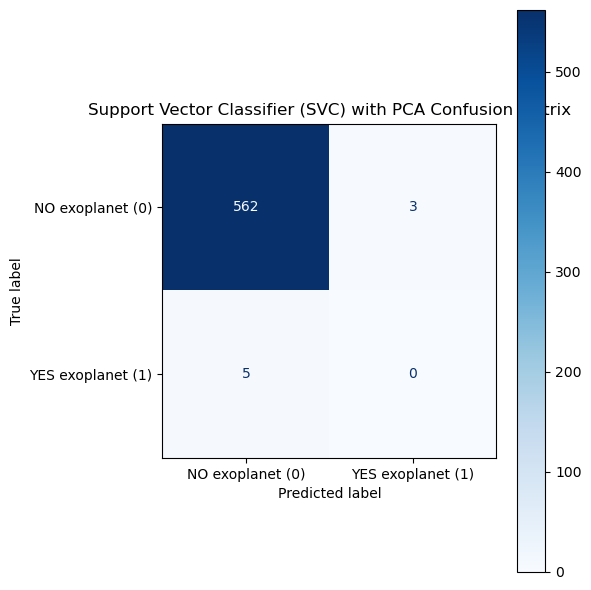


--- Training Decision Tree Classifier ---
Training Decision Tree model (CPU - scikit-learn)...
Decision Tree Training completed in 0.36 seconds.

--- Evaluating Decision Tree Classifier with PCA ---
Predicting on test data (CPU)...
CPU Prediction completed in 0.00 seconds.

Classification Report:
                   precision    recall  f1-score   support

 NO exoplanet (0)       0.99      1.00      0.99       565
YES exoplanet (1)       0.00      0.00      0.00         5

         accuracy                           0.99       570
        macro avg       0.50      0.50      0.50       570
     weighted avg       0.98      0.99      0.99       570


Confusion Matrix:


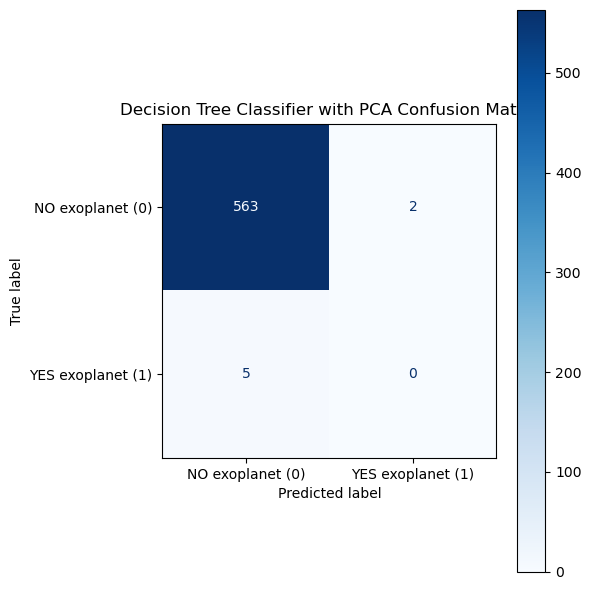


Script finished.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Core ML imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC  # Added SVC
from sklearn.tree import DecisionTreeClassifier # Added Decision Tree
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler

# --- Configuration ---
# Using relative paths assuming data is in the same directory as the script
# Or update these to absolute paths if needed
TRAIN_CSV_PATH = 'exoTrain.csv'
TEST_CSV_PATH = 'exoTest.csv'
RANDOM_STATE = 42
PCA_COMPONENTS = 100 # Number of components for PCA

# --- Data Loading ---
def load_data(train_path, test_path):
    """Loads training and testing data from CSV files."""
    try:
        print(f"Loading training data from: {train_path}")
        df_train = pd.read_csv(train_path)
        print(f"Loading testing data from: {test_path}")
        df_test = pd.read_csv(test_path)
        print("Data loaded successfully.")
        return df_train, df_test
    except FileNotFoundError:
        print(f"Error: One or both files not found. Please check paths:")
        print(f"- Train path: {train_path}")
        print(f"- Test path: {test_path}")
        return None, None
    except Exception as e:
        print(f"An error occurred during data loading: {e}")
        return None, None

# --- Data Preprocessing (CPU) ---
def preprocess_scale_pca_cpu(df_train, df_test, n_components):
    """Separates features/labels, scales features, applies PCA, returns numpy arrays."""
    print("Preprocessing data (CPU steps)...")
    # Separate features (X) and labels (y)
    X_train_raw = df_train.drop('LABEL', axis=1)
    y_train_raw = df_train['LABEL']
    X_test_raw = df_test.drop('LABEL', axis=1)
    y_test_raw = df_test['LABEL']

    # Convert labels: 1 (no exoplanet) -> 0, 2 (exoplanet) -> 1
    y_train = (y_train_raw - 1).astype(int).values # Get as numpy array
    y_test = (y_test_raw - 1).astype(int).values # Get as numpy array

    print(f"Original training set shape: {X_train_raw.shape}")
    print(f"Original test set shape: {X_test_raw.shape}")
    print(f"Training labels distribution:\n{pd.Series(y_train).value_counts()}")
    print(f"Test labels distribution:\n{pd.Series(y_test).value_counts()}")

    # Scale features using StandardScaler (CPU)
    print("Scaling features using StandardScaler (CPU)...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_raw.values)
    X_test_scaled = scaler.transform(X_test_raw.values)

    # Apply PCA to reduce dimensions
    print(f"Applying PCA to reduce feature dimensions to {n_components}...")
    pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    print(f"Explained variance ratio by {n_components} components: {np.sum(pca.explained_variance_ratio_):.4f}")
    print(f"Training set shape after PCA: {X_train_pca.shape}")
    print(f"Test set shape after PCA: {X_test_pca.shape}")

    print("CPU Preprocessing, Scaling, and PCA complete.")
    # Return scaler, pca object, and processed data + labels
    return scaler, pca, X_train_pca, y_train, X_test_pca, y_test

# --- Oversampling (CPU) ---
def oversample_cpu(X_train_processed, y_train):
    """Performs oversampling on the processed training data (CPU)."""
    print("Oversampling training data using RandomOverSampler (CPU)...")
    oversampler = RandomOverSampler(sampling_strategy='auto', random_state=RANDOM_STATE)
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_processed, y_train)
    print(f"Training data shape after oversampling: {X_train_resampled.shape}")
    print(f"Training labels distribution after oversampling:\n{pd.Series(y_train_resampled).value_counts()}")
    return X_train_resampled, y_train_resampled

# --- Model Training (CPU) ---
def train_logistic_regression(X_train_processed, y_train_processed):
    """Trains an optimized Logistic Regression model on the CPU using scikit-learn."""
    print("\n--- Training Logistic Regression ---")
    print("Training Logistic Regression model (CPU - scikit-learn)...")
    model = LogisticRegression(
        solver='saga',  # Faster solver for potentially large datasets after oversampling
        max_iter=500,   # Adjusted iterations
        tol=1e-2,       # Higher tolerance for potentially faster convergence
        random_state=RANDOM_STATE,
        verbose=0       # Set to 1 to see convergence messages
    )
    start_time = time.time()
    model.fit(X_train_processed, y_train_processed)
    end_time = time.time()
    print(f"Logistic Regression Training completed in {end_time - start_time:.2f} seconds.")
    return model

def train_svc(X_train_processed, y_train_processed):
    """Trains a Support Vector Classifier model on the CPU using scikit-learn."""
    print("\n--- Training Support Vector Classifier (SVC) ---")
    print("Training SVC model (CPU - scikit-learn)...")
    # SVC can be sensitive to hyperparameters (C, kernel, gamma).
    # Consider using GridSearchCV for tuning if needed.
    # Using PCA-reduced data might make training faster than with original features.
    # Set probability=True to enable predict_proba (slower training)
    model = SVC(probability=True, random_state=RANDOM_STATE)
    start_time = time.time()
    model.fit(X_train_processed, y_train_processed)
    end_time = time.time()
    print(f"SVC Training completed in {end_time - start_time:.2f} seconds.")
    return model

def train_decision_tree(X_train_processed, y_train_processed):
    """Trains a Decision Tree Classifier model on the CPU using scikit-learn."""
    print("\n--- Training Decision Tree Classifier ---")
    print("Training Decision Tree model (CPU - scikit-learn)...")
    # Decision Trees can be prone to overfitting. Consider tuning max_depth, min_samples_split etc.
    model = DecisionTreeClassifier(random_state=RANDOM_STATE)
    start_time = time.time()
    model.fit(X_train_processed, y_train_processed)
    end_time = time.time()
    print(f"Decision Tree Training completed in {end_time - start_time:.2f} seconds.")
    return model

# --- Model Evaluation (CPU) ---
def evaluate_model(model, X_test_processed, y_test, model_name="Model"):
    """Evaluates the model on the processed test set and prints metrics."""
    print(f"\n--- Evaluating {model_name} ---")
    y_pred = None
    y_pred_proba = None

    try:
        print("Predicting on test data (CPU)...")
        start_time = time.time()
        # Use the model's predict method
        y_pred = model.predict(X_test_processed)
        # Get probabilities if the model supports it
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test_processed)[:, 1] # Probability of positive class (1)
        else:
            print("Model does not support predict_proba.")
        end_time = time.time()
        print(f"CPU Prediction completed in {end_time - start_time:.2f} seconds.")

        # Ensure predictions are integers
        y_pred = y_pred.astype(int)

        # Get model classes
        try:
             model_classes = model.classes_
        except AttributeError:
             print("Warning: Could not get model.classes_, assuming [0, 1]")
             model_classes = np.array([0, 1])

        # Print Classification Report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=["NO exoplanet (0)", "YES exoplanet (1)"], labels=model_classes))

        # Plot Confusion Matrix
        print("\nConfusion Matrix:")
        cm = confusion_matrix(y_test, y_pred, labels=model_classes)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NO exoplanet (0)", "YES exoplanet (1)"])

        fig, ax = plt.subplots(figsize=(6, 6))
        disp.plot(ax=ax, cmap='Blues', values_format='d')
        ax.set_title(f'{model_name} Confusion Matrix')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An unexpected error occurred during evaluation: {e}")


# --- Main Execution ---
if __name__ == "__main__":
    print("Starting Exoplanet Detection Script (LogReg, SVC, DT with PCA)...")

    # 1. Load Data
    df_train, df_test = load_data(TRAIN_CSV_PATH, TEST_CSV_PATH)

    if df_train is not None and df_test is not None:
        # 2. Preprocess Data (Scale + PCA)
        scaler, pca, X_train_pca, y_train, X_test_pca, y_test = preprocess_scale_pca_cpu(df_train, df_test, n_components=PCA_COMPONENTS)

        # 3. Oversample PCA'd Training Data
        X_train_resampled, y_train_resampled = oversample_cpu(X_train_pca, y_train)

        # --- Logistic Regression ---
        log_reg_model = train_logistic_regression(X_train_resampled, y_train_resampled)
        evaluate_model(log_reg_model, X_test_pca, y_test,
                       model_name="Logistic Regression with PCA")

        # --- Support Vector Classifier ---
        svc_model = train_svc(X_train_resampled, y_train_resampled)
        evaluate_model(svc_model, X_test_pca, y_test,
                       model_name="Support Vector Classifier (SVC) with PCA")

        # --- Decision Tree Classifier ---
        dt_model = train_decision_tree(X_train_resampled, y_train_resampled)
        evaluate_model(dt_model, X_test_pca, y_test,
                       model_name="Decision Tree Classifier with PCA")

        print("\nScript finished.")
    else:
        print("\nScript aborted due to data loading errors.")

Starting Exoplanet Detection Script (LogReg, SVC, DT, RF, GB with PCA)...
Loading training data from: exoTrain.csv
Loading testing data from: exoTest.csv
Data loaded successfully.
Preprocessing data (CPU steps)...
Original training set shape: (5087, 3197)
Original test set shape: (570, 3197)
Training labels distribution:
0    5050
1      37
Name: count, dtype: int64
Test labels distribution:
0    565
1      5
Name: count, dtype: int64
Scaling features using StandardScaler (CPU)...
Applying PCA to reduce feature dimensions to 100...
Explained variance ratio by 100 components: 0.9998
Training set shape after PCA: (5087, 100)
Test set shape after PCA: (570, 100)
CPU Preprocessing, Scaling, and PCA complete.
Oversampling training data using RandomOverSampler (CPU)...
Training data shape after oversampling: (10100, 100)
Training labels distribution after oversampling:
1    5050
0    5050
Name: count, dtype: int64

--- Training Logistic Regression ---
Training Logistic Regression model (CPU 

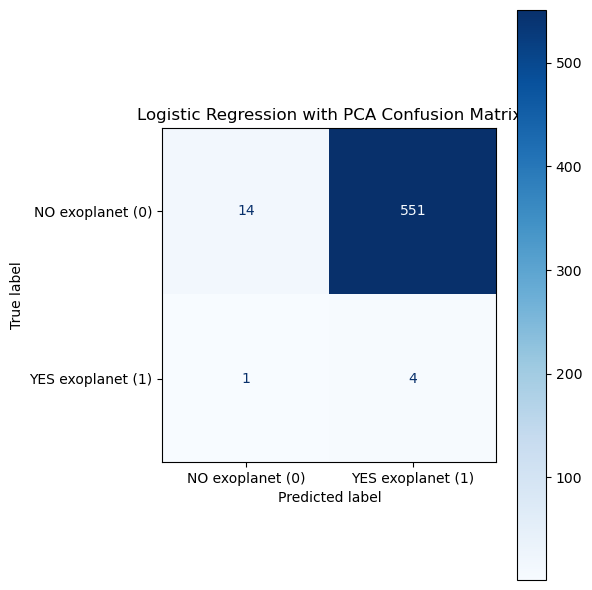


--- Training Support Vector Classifier (SVC) ---
Training SVC model (CPU - scikit-learn)...
SVC Training completed in 55.06 seconds.

--- Evaluating Support Vector Classifier (SVC) with PCA ---
Predicting on test data (CPU)...
CPU Prediction completed in 0.99 seconds.

Classification Report:
                   precision    recall  f1-score   support

 NO exoplanet (0)       0.99      0.99      0.99       565
YES exoplanet (1)       0.00      0.00      0.00         5

         accuracy                           0.99       570
        macro avg       0.50      0.50      0.50       570
     weighted avg       0.98      0.99      0.98       570


Confusion Matrix:


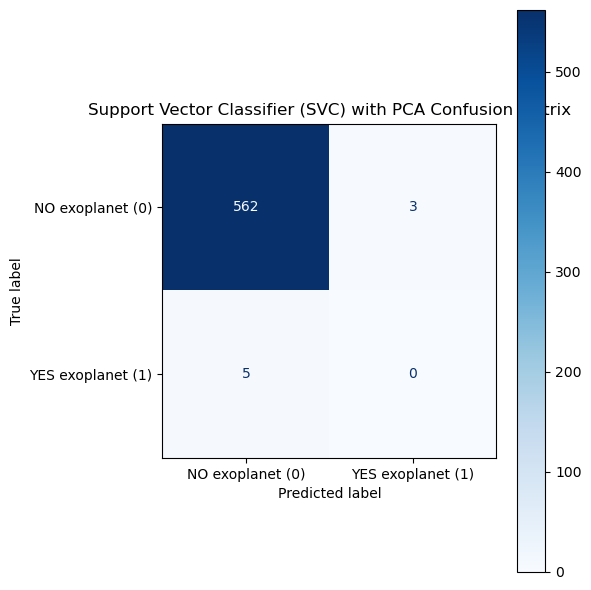


--- Training Decision Tree Classifier ---
Training Decision Tree model (CPU - scikit-learn)...
Decision Tree Training completed in 0.31 seconds.

--- Evaluating Decision Tree Classifier with PCA ---
Predicting on test data (CPU)...
CPU Prediction completed in 0.00 seconds.

Classification Report:
                   precision    recall  f1-score   support

 NO exoplanet (0)       0.99      1.00      0.99       565
YES exoplanet (1)       0.00      0.00      0.00         5

         accuracy                           0.99       570
        macro avg       0.50      0.50      0.50       570
     weighted avg       0.98      0.99      0.99       570


Confusion Matrix:


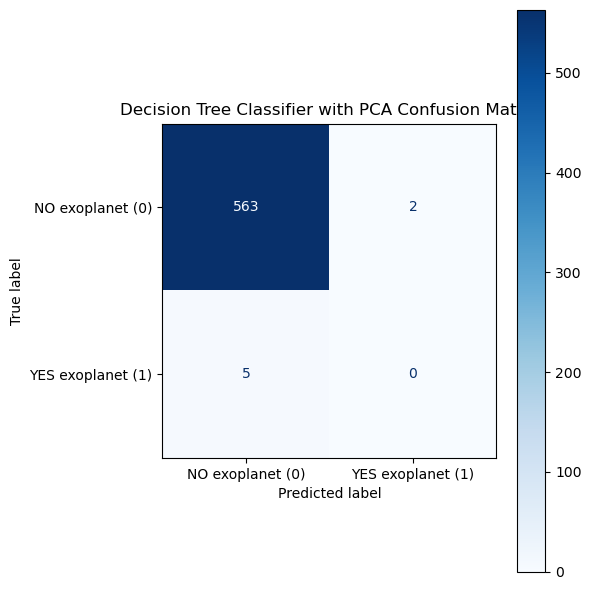


--- Training Random Forest Classifier ---
Training Random Forest model (CPU - scikit-learn)...
Random Forest Training completed in 0.36 seconds.

--- Evaluating Random Forest Classifier with PCA ---
Predicting on test data (CPU)...
CPU Prediction completed in 0.06 seconds.

Classification Report:
                   precision    recall  f1-score   support

 NO exoplanet (0)       0.99      1.00      1.00       565
YES exoplanet (1)       0.00      0.00      0.00         5

         accuracy                           0.99       570
        macro avg       0.50      0.50      0.50       570
     weighted avg       0.98      0.99      0.99       570


Confusion Matrix:


C:\Users\krish\anaconda3\envs\new_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\krish\anaconda3\envs\new_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\krish\anaconda3\envs\new_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


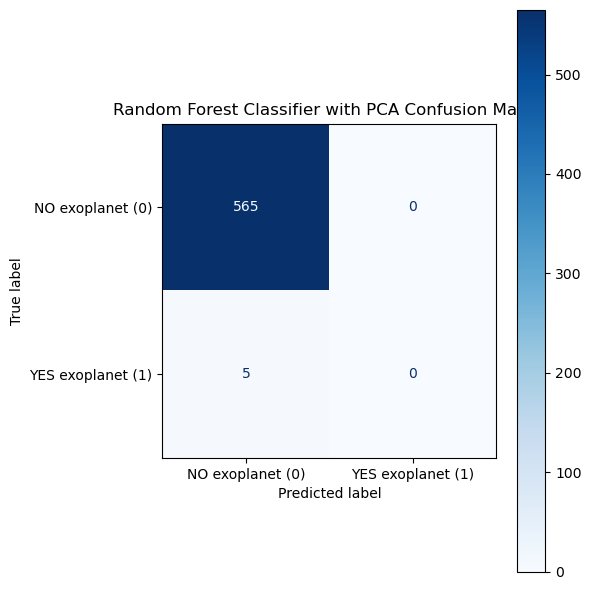


--- Training Gradient Boosting Classifier ---
Training Gradient Boosting model (CPU - scikit-learn)...
Gradient Boosting Training completed in 18.64 seconds.

--- Evaluating Gradient Boosting Classifier with PCA ---
Predicting on test data (CPU)...
CPU Prediction completed in 0.00 seconds.

Classification Report:
                   precision    recall  f1-score   support

 NO exoplanet (0)       0.99      1.00      1.00       565
YES exoplanet (1)       0.00      0.00      0.00         5

         accuracy                           0.99       570
        macro avg       0.50      0.50      0.50       570
     weighted avg       0.98      0.99      0.99       570


Confusion Matrix:


C:\Users\krish\anaconda3\envs\new_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\krish\anaconda3\envs\new_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\krish\anaconda3\envs\new_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


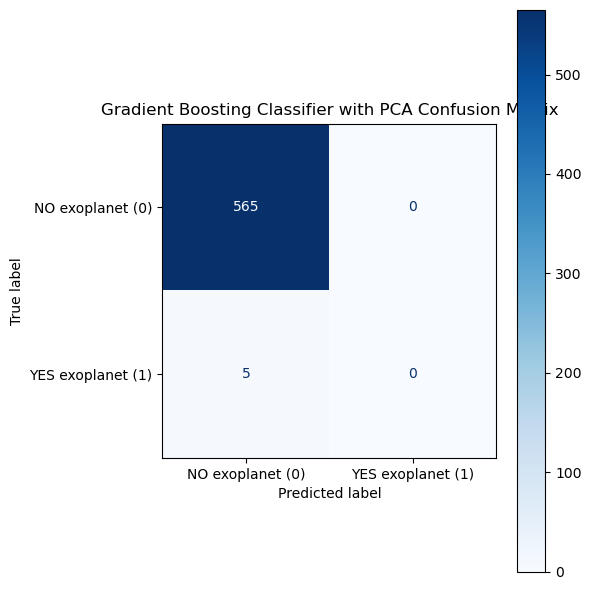


Script finished.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Core ML imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier # Added Ensemble models
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler

# --- Configuration ---
# Using relative paths assuming data is in the same directory as the script
# Or update these to absolute paths if needed
TRAIN_CSV_PATH = 'exoTrain.csv'
TEST_CSV_PATH = 'exoTest.csv'
RANDOM_STATE = 42
PCA_COMPONENTS = 100 # Number of components for PCA

# --- Data Loading ---
def load_data(train_path, test_path):
    """Loads training and testing data from CSV files."""
    try:
        print(f"Loading training data from: {train_path}")
        df_train = pd.read_csv(train_path)
        print(f"Loading testing data from: {test_path}")
        df_test = pd.read_csv(test_path)
        print("Data loaded successfully.")
        return df_train, df_test
    except FileNotFoundError:
        print(f"Error: One or both files not found. Please check paths:")
        print(f"- Train path: {train_path}")
        print(f"- Test path: {test_path}")
        return None, None
    except Exception as e:
        print(f"An error occurred during data loading: {e}")
        return None, None

# --- Data Preprocessing (CPU) ---
def preprocess_scale_pca_cpu(df_train, df_test, n_components):
    """Separates features/labels, scales features, applies PCA, returns numpy arrays."""
    print("Preprocessing data (CPU steps)...")
    # Separate features (X) and labels (y)
    X_train_raw = df_train.drop('LABEL', axis=1)
    y_train_raw = df_train['LABEL']
    X_test_raw = df_test.drop('LABEL', axis=1)
    y_test_raw = df_test['LABEL']

    # Convert labels: 1 (no exoplanet) -> 0, 2 (exoplanet) -> 1
    y_train = (y_train_raw - 1).astype(int).values # Get as numpy array
    y_test = (y_test_raw - 1).astype(int).values # Get as numpy array

    print(f"Original training set shape: {X_train_raw.shape}")
    print(f"Original test set shape: {X_test_raw.shape}")
    print(f"Training labels distribution:\n{pd.Series(y_train).value_counts()}")
    print(f"Test labels distribution:\n{pd.Series(y_test).value_counts()}")

    # Scale features using StandardScaler (CPU)
    print("Scaling features using StandardScaler (CPU)...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_raw.values)
    X_test_scaled = scaler.transform(X_test_raw.values)

    # Apply PCA to reduce dimensions
    print(f"Applying PCA to reduce feature dimensions to {n_components}...")
    pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    print(f"Explained variance ratio by {n_components} components: {np.sum(pca.explained_variance_ratio_):.4f}")
    print(f"Training set shape after PCA: {X_train_pca.shape}")
    print(f"Test set shape after PCA: {X_test_pca.shape}")

    print("CPU Preprocessing, Scaling, and PCA complete.")
    # Return scaler, pca object, and processed data + labels
    return scaler, pca, X_train_pca, y_train, X_test_pca, y_test

# --- Oversampling (CPU) ---
def oversample_cpu(X_train_processed, y_train):
    """Performs oversampling on the processed training data (CPU)."""
    print("Oversampling training data using RandomOverSampler (CPU)...")
    oversampler = RandomOverSampler(sampling_strategy='auto', random_state=RANDOM_STATE)
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_processed, y_train)
    print(f"Training data shape after oversampling: {X_train_resampled.shape}")
    print(f"Training labels distribution after oversampling:\n{pd.Series(y_train_resampled).value_counts()}")
    return X_train_resampled, y_train_resampled

# --- Model Training (CPU) ---
def train_logistic_regression(X_train_processed, y_train_processed):
    """Trains an optimized Logistic Regression model on the CPU using scikit-learn."""
    print("\n--- Training Logistic Regression ---")
    print("Training Logistic Regression model (CPU - scikit-learn)...")
    model = LogisticRegression(
        solver='saga',  # Faster solver for potentially large datasets after oversampling
        max_iter=500,   # Adjusted iterations
        tol=1e-2,       # Higher tolerance for potentially faster convergence
        random_state=RANDOM_STATE,
        verbose=0       # Set to 1 to see convergence messages
    )
    start_time = time.time()
    model.fit(X_train_processed, y_train_processed)
    end_time = time.time()
    print(f"Logistic Regression Training completed in {end_time - start_time:.2f} seconds.")
    return model

def train_svc(X_train_processed, y_train_processed):
    """Trains a Support Vector Classifier model on the CPU using scikit-learn."""
    print("\n--- Training Support Vector Classifier (SVC) ---")
    print("Training SVC model (CPU - scikit-learn)...")
    # SVC can be sensitive to hyperparameters (C, kernel, gamma).
    # Consider using GridSearchCV for tuning if needed.
    # Using PCA-reduced data might make training faster than with original features.
    # Set probability=True to enable predict_proba (slower training)
    model = SVC(probability=True, random_state=RANDOM_STATE)
    start_time = time.time()
    model.fit(X_train_processed, y_train_processed)
    end_time = time.time()
    print(f"SVC Training completed in {end_time - start_time:.2f} seconds.")
    return model

def train_decision_tree(X_train_processed, y_train_processed):
    """Trains a Decision Tree Classifier model on the CPU using scikit-learn."""
    print("\n--- Training Decision Tree Classifier ---")
    print("Training Decision Tree model (CPU - scikit-learn)...")
    # Decision Trees can be prone to overfitting. Consider tuning max_depth, min_samples_split etc.
    model = DecisionTreeClassifier(random_state=RANDOM_STATE)
    start_time = time.time()
    model.fit(X_train_processed, y_train_processed)
    end_time = time.time()
    print(f"Decision Tree Training completed in {end_time - start_time:.2f} seconds.")
    return model

def train_random_forest(X_train_processed, y_train_processed):
    """Trains a Random Forest Classifier model on the CPU using scikit-learn."""
    print("\n--- Training Random Forest Classifier ---")
    print("Training Random Forest model (CPU - scikit-learn)...")
    # Random Forest parameters like n_estimators, max_depth can be tuned.
    # n_jobs=-1 uses all available CPU cores for potentially faster training.
    model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
    start_time = time.time()
    model.fit(X_train_processed, y_train_processed)
    end_time = time.time()
    print(f"Random Forest Training completed in {end_time - start_time:.2f} seconds.")
    return model

def train_gradient_boosting(X_train_processed, y_train_processed):
    """Trains a Gradient Boosting Classifier model on the CPU using scikit-learn."""
    print("\n--- Training Gradient Boosting Classifier ---")
    print("Training Gradient Boosting model (CPU - scikit-learn)...")
    # Gradient Boosting parameters (n_estimators, learning_rate, max_depth) are important for tuning.
    # Using default parameters here as a baseline.
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=RANDOM_STATE)
    start_time = time.time()
    model.fit(X_train_processed, y_train_processed)
    end_time = time.time()
    print(f"Gradient Boosting Training completed in {end_time - start_time:.2f} seconds.")
    return model

# --- Model Evaluation (CPU) ---
def evaluate_model(model, X_test_processed, y_test, model_name="Model"):
    """Evaluates the model on the processed test set and prints metrics."""
    print(f"\n--- Evaluating {model_name} ---")
    y_pred = None
    y_pred_proba = None

    try:
        print("Predicting on test data (CPU)...")
        start_time = time.time()
        # Use the model's predict method
        y_pred = model.predict(X_test_processed)
        # Get probabilities if the model supports it
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test_processed)[:, 1] # Probability of positive class (1)
        else:
            print("Model does not support predict_proba.")
        end_time = time.time()
        print(f"CPU Prediction completed in {end_time - start_time:.2f} seconds.")

        # Ensure predictions are integers
        y_pred = y_pred.astype(int)

        # Get model classes
        try:
             model_classes = model.classes_
        except AttributeError:
             print("Warning: Could not get model.classes_, assuming [0, 1]")
             model_classes = np.array([0, 1])

        # Print Classification Report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=["NO exoplanet (0)", "YES exoplanet (1)"], labels=model_classes))

        # Plot Confusion Matrix
        print("\nConfusion Matrix:")
        cm = confusion_matrix(y_test, y_pred, labels=model_classes)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NO exoplanet (0)", "YES exoplanet (1)"])

        fig, ax = plt.subplots(figsize=(6, 6))
        disp.plot(ax=ax, cmap='Blues', values_format='d')
        ax.set_title(f'{model_name} Confusion Matrix')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An unexpected error occurred during evaluation: {e}")


# --- Main Execution ---
if __name__ == "__main__":
    print("Starting Exoplanet Detection Script (LogReg, SVC, DT, RF, GB with PCA)...")

    # 1. Load Data
    df_train, df_test = load_data(TRAIN_CSV_PATH, TEST_CSV_PATH)

    if df_train is not None and df_test is not None:
        # 2. Preprocess Data (Scale + PCA)
        scaler, pca, X_train_pca, y_train, X_test_pca, y_test = preprocess_scale_pca_cpu(df_train, df_test, n_components=PCA_COMPONENTS)

        # 3. Oversample PCA'd Training Data
        X_train_resampled, y_train_resampled = oversample_cpu(X_train_pca, y_train)

        # --- Logistic Regression ---
        log_reg_model = train_logistic_regression(X_train_resampled, y_train_resampled)
        evaluate_model(log_reg_model, X_test_pca, y_test,
                       model_name="Logistic Regression with PCA")

        # --- Support Vector Classifier ---
        svc_model = train_svc(X_train_resampled, y_train_resampled)
        evaluate_model(svc_model, X_test_pca, y_test,
                       model_name="Support Vector Classifier (SVC) with PCA")

        # --- Decision Tree Classifier ---
        dt_model = train_decision_tree(X_train_resampled, y_train_resampled)
        evaluate_model(dt_model, X_test_pca, y_test,
                       model_name="Decision Tree Classifier with PCA")

        # --- Random Forest Classifier ---
        rf_model = train_random_forest(X_train_resampled, y_train_resampled)
        evaluate_model(rf_model, X_test_pca, y_test,
                       model_name="Random Forest Classifier with PCA")

        # --- Gradient Boosting Classifier ---
        gb_model = train_gradient_boosting(X_train_resampled, y_train_resampled)
        evaluate_model(gb_model, X_test_pca, y_test,
                       model_name="Gradient Boosting Classifier with PCA")


        print("\nScript finished.")
    else:
        print("\nScript aborted due to data loading errors.")


Starting Exoplanet Detection Script (CNN with PCA)...
Loading training data from: exoTrain.csv
Loading testing data from: exoTest.csv
Data loaded successfully.
Preprocessing data (CPU steps)...
Original training set shape: (5087, 3197)
Original test set shape: (570, 3197)
Training labels distribution:
0    5050
1      37
Name: count, dtype: int64
Test labels distribution:
0    565
1      5
Name: count, dtype: int64
Scaling features using StandardScaler (CPU)...
Applying PCA to reduce feature dimensions to 100...
Explained variance ratio by 100 components: 0.9998
Training set shape after PCA: (5087, 100)
Test set shape after PCA: (570, 100)
CPU Preprocessing, Scaling, and PCA complete.

Split training data into 4069 for training, 1018 for validation.
Oversampling training data using RandomOverSampler (CPU)...
Training data shape after oversampling: (8078, 100)
Training labels distribution after oversampling:
0    4039
1    4039
Name: count, dtype: int64

Reshaped data for CNN input:
Tra

Model: "Exoplanet_1D_CNN_on_PCA"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 100, 64)        │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 50, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 436,225 (1.66 MB)

 Trainable params: 435,585 (1.66 MB)

 Non-trainable params: 640 (2.50 KB)

None

--- Training CNN Model ---
Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6782 - loss: 0.6711 - val_accuracy: 0.0275 - val_loss: 1.3244 - learning_rate: 0.0010
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8085 - loss: 0.4076 - val_accuracy: 0.0285 - val_loss: 1.1979 - learning_rate: 0.0010
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8654 - loss: 0.3073 - val_accuracy: 0.9754 - val_loss: 0.4441 - learning_rate: 0.0010
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9091 - loss: 0.2251 - val_accuracy: 0.9872 - val_loss: 0.1650 - learning_rate: 0.0010
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9295 - loss: 0.1686 - val_accuracy: 0.9587 - val_loss: 0.5558 - learning_rate: 0.0010
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9507 - loss: 0.1230 - val_accuracy: 0.9804 - val_loss: 0.4455 - learning_rate: 0.0010
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/s

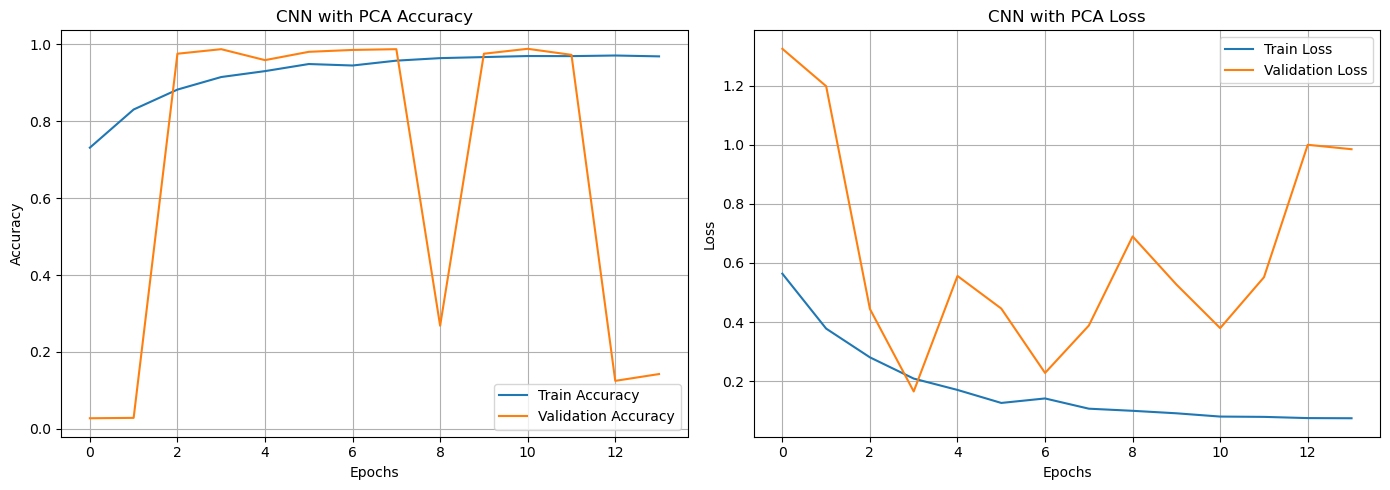


--- Evaluating CNN with PCA ---
Test Loss: 0.1480
Test Accuracy: 0.9912
Predicting on test data...
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
Prediction completed in 0.29 seconds.

Classification Report:
                   precision    recall  f1-score   support

 NO exoplanet (0)       0.99      1.00      1.00       565
YES exoplanet (1)       0.00      0.00      0.00         5

         accuracy                           0.99       570
        macro avg       0.50      0.50      0.50       570
     weighted avg       0.98      0.99      0.99       570


Confusion Matrix:


C:\Users\krish\anaconda3\envs\new_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\krish\anaconda3\envs\new_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\krish\anaconda3\envs\new_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


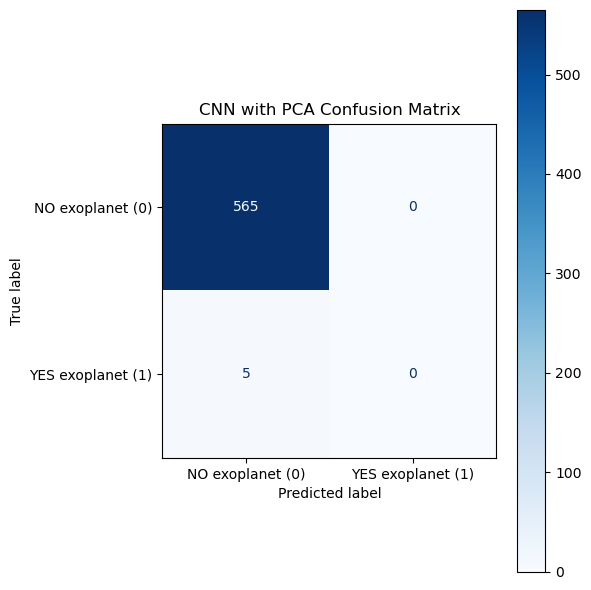


Script finished.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Core ML imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler

# TensorFlow / Keras imports for CNN
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks

# --- Configuration ---
# Using relative paths assuming data is in the same directory as the script
# Or update these to absolute paths if needed
TRAIN_CSV_PATH = 'exoTrain.csv'
TEST_CSV_PATH = 'exoTest.csv'
RANDOM_STATE = 42
PCA_COMPONENTS = 100 # Number of components for PCA
VALIDATION_SPLIT_SIZE = 0.2 # 20% of training data for validation
EPOCHS = 50 # Number of training epochs for the CNN
BATCH_SIZE = 64 # Batch size for CNN training

# --- Data Loading ---
def load_data(train_path, test_path):
    """Loads training and testing data from CSV files."""
    try:
        print(f"Loading training data from: {train_path}")
        df_train = pd.read_csv(train_path)
        print(f"Loading testing data from: {test_path}")
        df_test = pd.read_csv(test_path)
        print("Data loaded successfully.")
        return df_train, df_test
    except FileNotFoundError:
        print(f"Error: One or both files not found. Please check paths:")
        print(f"- Train path: {train_path}")
        print(f"- Test path: {test_path}")
        return None, None
    except Exception as e:
        print(f"An error occurred during data loading: {e}")
        return None, None

# --- Data Preprocessing (CPU) ---
def preprocess_scale_pca_cpu(df_train, df_test, n_components):
    """Separates features/labels, scales features, applies PCA, returns numpy arrays."""
    print("Preprocessing data (CPU steps)...")
    # Separate features (X) and labels (y)
    X_train_raw = df_train.drop('LABEL', axis=1)
    y_train_raw = df_train['LABEL']
    X_test_raw = df_test.drop('LABEL', axis=1)
    y_test_raw = df_test['LABEL']

    # Convert labels: 1 (no exoplanet) -> 0, 2 (exoplanet) -> 1
    y_train = (y_train_raw - 1).astype(int).values # Get as numpy array
    y_test = (y_test_raw - 1).astype(int).values # Get as numpy array

    print(f"Original training set shape: {X_train_raw.shape}")
    print(f"Original test set shape: {X_test_raw.shape}")
    print(f"Training labels distribution:\n{pd.Series(y_train).value_counts()}")
    print(f"Test labels distribution:\n{pd.Series(y_test).value_counts()}")

    # Scale features using StandardScaler (CPU)
    print("Scaling features using StandardScaler (CPU)...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_raw.values)
    X_test_scaled = scaler.transform(X_test_raw.values)

    # Apply PCA to reduce dimensions
    print(f"Applying PCA to reduce feature dimensions to {n_components}...")
    pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    print(f"Explained variance ratio by {n_components} components: {np.sum(pca.explained_variance_ratio_):.4f}")
    print(f"Training set shape after PCA: {X_train_pca.shape}")
    print(f"Test set shape after PCA: {X_test_pca.shape}")

    print("CPU Preprocessing, Scaling, and PCA complete.")
    # Return scaler, pca object, and processed data + labels
    return scaler, pca, X_train_pca, y_train, X_test_pca, y_test

# --- Oversampling (CPU) ---
def oversample_cpu(X_train_processed, y_train):
    """Performs oversampling on the processed training data (CPU)."""
    print("Oversampling training data using RandomOverSampler (CPU)...")
    oversampler = RandomOverSampler(sampling_strategy='auto', random_state=RANDOM_STATE)
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_processed, y_train)
    print(f"Training data shape after oversampling: {X_train_resampled.shape}")
    print(f"Training labels distribution after oversampling:\n{pd.Series(y_train_resampled).value_counts()}")
    return X_train_resampled, y_train_resampled

# --- CNN Model Definition ---
def build_cnn_model(input_shape):
    """Builds a 1D CNN model using Keras."""
    print("\n--- Building CNN Model ---")
    model = models.Sequential(name="Exoplanet_1D_CNN_on_PCA")

    # Input Layer (treating PCA components as a sequence)
    model.add(layers.Input(shape=input_shape))

    # Reshape for Conv1D: (batch_size, steps, channels)
    # Here: steps = PCA_COMPONENTS, channels = 1
    # model.add(layers.Reshape((input_shape[0], 1))) # Reshape inside model if needed, or reshape data beforehand

    # Convolutional Block 1
    model.add(layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Dropout(0.25))

    # Convolutional Block 2
    model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Dropout(0.25))

    # Flatten and Dense Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    # Output Layer
    model.add(layers.Dense(1, activation='sigmoid')) # Sigmoid for binary classification

    # Compile Model
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    print(model.summary())
    return model

# --- CNN Model Training ---
def train_cnn_model(model, X_train_reshaped, y_train_ovs, X_val_reshaped, y_val, epochs, batch_size):
    """Trains the compiled Keras CNN model."""
    print("\n--- Training CNN Model ---")

    # Callbacks for training
    # EarlyStopping: Stop training if validation loss doesn't improve
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    # ReduceLROnPlateau: Reduce learning rate if validation loss plateaus
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

    start_time = time.time()
    history = model.fit(
        X_train_reshaped,
        y_train_ovs,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val_reshaped, y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=1 # Set to 1 or 2 to see epoch progress
    )
    end_time = time.time()
    print(f"CNN Training completed in {end_time - start_time:.2f} seconds.")
    return history

# --- Plot Training History ---
def plot_training_history(history, model_name):
    """Plots accuracy and loss curves for training and validation sets."""
    print(f"\n--- Plotting Training History for {model_name} ---")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Accuracy
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{model_name} Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot Loss
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{model_name} Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# --- CNN Model Evaluation ---
def evaluate_cnn_model(model, X_test_reshaped, y_test, model_name="CNN Model"):
    """Evaluates the trained CNN model on the test set."""
    print(f"\n--- Evaluating {model_name} ---")

    # Evaluate loss and accuracy on test set
    loss, accuracy = model.evaluate(X_test_reshaped, y_test, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    # Predict probabilities and classes
    print("Predicting on test data...")
    start_time = time.time()
    y_pred_proba = model.predict(X_test_reshaped).flatten() # Flatten output
    y_pred = (y_pred_proba > 0.5).astype(int) # Threshold probabilities
    end_time = time.time()
    print(f"Prediction completed in {end_time - start_time:.2f} seconds.")

    # Print Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=["NO exoplanet (0)", "YES exoplanet (1)"]))

    # Plot Confusion Matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NO exoplanet (0)", "YES exoplanet (1)"])

    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f'{model_name} Confusion Matrix')
    plt.tight_layout()
    plt.show()


# --- Main Execution ---
if __name__ == "__main__":
    print("Starting Exoplanet Detection Script (CNN with PCA)...")

    # 1. Load Data
    df_train, df_test = load_data(TRAIN_CSV_PATH, TEST_CSV_PATH)

    if df_train is not None and df_test is not None:
        # 2. Preprocess Data (Scale + PCA)
        scaler, pca, X_train_pca, y_train, X_test_pca, y_test = preprocess_scale_pca_cpu(
            df_train, df_test, n_components=PCA_COMPONENTS
        )

        # 3. Split Training data for Validation (before oversampling)
        X_train_split_pca, X_val_pca, y_train_split, y_val = train_test_split(
            X_train_pca, y_train,
            test_size=VALIDATION_SPLIT_SIZE,
            random_state=RANDOM_STATE,
            stratify=y_train # Ensure similar class distribution in train/val splits
        )
        print(f"\nSplit training data into {len(X_train_split_pca)} for training, {len(X_val_pca)} for validation.")

        # 4. Oversample the *training* split only
        X_train_ovs_pca, y_train_ovs = oversample_cpu(X_train_split_pca, y_train_split)

        # 5. Reshape Data for 1D CNN
        # Reshape to (num_samples, steps=PCA_COMPONENTS, channels=1)
        X_train_reshaped = X_train_ovs_pca.reshape((X_train_ovs_pca.shape[0], PCA_COMPONENTS, 1))
        X_val_reshaped = X_val_pca.reshape((X_val_pca.shape[0], PCA_COMPONENTS, 1))
        X_test_reshaped = X_test_pca.reshape((X_test_pca.shape[0], PCA_COMPONENTS, 1))
        print(f"\nReshaped data for CNN input:")
        print(f"Training data shape: {X_train_reshaped.shape}")
        print(f"Validation data shape: {X_val_reshaped.shape}")
        print(f"Test data shape: {X_test_reshaped.shape}")

        # 6. Build CNN Model
        cnn_model = build_cnn_model(input_shape=(PCA_COMPONENTS, 1))

        # 7. Train CNN Model
        history = train_cnn_model(
            cnn_model,
            X_train_reshaped, y_train_ovs,
            X_val_reshaped, y_val,
            epochs=EPOCHS, batch_size=BATCH_SIZE
        )

        # 8. Plot Training History
        plot_training_history(history, "CNN with PCA")

        # 9. Evaluate CNN Model on Test Set
        # Note: The model automatically uses the best weights restored by EarlyStopping
        evaluate_cnn_model(cnn_model, X_test_reshaped, y_test, model_name="CNN with PCA")

        print("\nScript finished.")
    else:
        print("\nScript aborted due to data loading errors.")


Starting Exoplanet Detection Script (CNN on Scaled Sequence)...
Loading training data from: exoTrain.csv
Loading testing data from: exoTest.csv
Data loaded successfully.
Detected 3197 flux features.
Preprocessing data (CPU steps)...
Original training set shape: (5087, 3197)
Original test set shape: (570, 3197)
Training labels distribution:
0    5050
1      37
Name: count, dtype: int64
Test labels distribution:
0    565
1      5
Name: count, dtype: int64
Scaling features using StandardScaler (CPU)...
CPU Preprocessing and Scaling complete.

Split training data into 4069 for training, 1018 for validation.
Oversampling training data using RandomOverSampler (CPU)...
Training data shape after oversampling: (8078, 3197)
Training labels distribution after oversampling:
0    4039
1    4039
Name: count, dtype: int64

Reshaped data for CNN input:
Training data shape: (8078, 3197, 1)
Validation data shape: (1018, 3197, 1)
Test data shape: (570, 3197, 1)

--- Building CNN Model for Raw Sequence --

Model: "Exoplanet_1D_CNN_on_Sequence"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 3197, 64)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3197, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 1065, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1065, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 1065, 128)      │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1065, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 355, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 355, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 355, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 355, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 177, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 177, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 45312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    11,600,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,743,361 (44.80 MB)

 Trainable params: 11,741,953 (44.79 MB)

 Non-trainable params: 1,408 (5.50 KB)

None

--- Training CNN Model ---
Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 100s 768ms/step - accuracy: 0.7356 - loss: 0.5798 - val_accuracy: 0.9833 - val_loss: 0.1885 - learning_rate: 5.0000e-04
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 93s 733ms/step - accuracy: 0.9019 - loss: 0.2638 - val_accuracy: 0.9882 - val_loss: 0.0623 - learning_rate: 5.0000e-04
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 89s 702ms/step - accuracy: 0.9395 - loss: 0.1809 - val_accuracy: 0.9902 - val_loss: 0.0745 - learning_rate: 5.0000e-04
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 95s 746ms/step - accuracy: 0.9549 - loss: 0.1356 - val_accuracy: 0.9912 - val_loss: 0.0602 - learning_rate: 5.0000e-04
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 93s 729ms/step - accuracy: 0.9631 - loss: 0.1051 - val_accuracy: 0.9912 - val_loss: 0.0687 - learning_rate: 5.0000e-04
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 97s 760ms/step - accuracy: 0.9685 - loss: 0.0925 - val_accuracy: 0.9931 - val_loss: 0.0369 - learning_rate: 5.0000e-04
Epoch 7/50
1

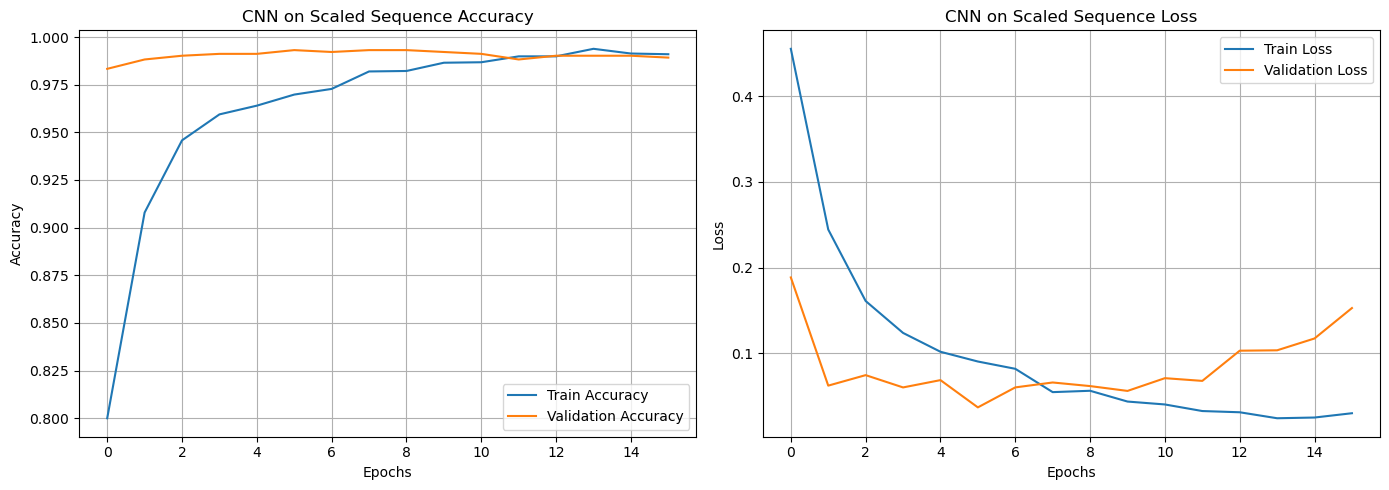


--- Evaluating CNN on Scaled Sequence ---
Test Loss: 0.0464
Test Accuracy: 0.9912
Predicting on test data...
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step 
Prediction completed in 1.08 seconds.

Classification Report:
                   precision    recall  f1-score   support

 NO exoplanet (0)       0.99      1.00      1.00       565
YES exoplanet (1)       0.00      0.00      0.00         5

         accuracy                           0.99       570
        macro avg       0.50      0.50      0.50       570
     weighted avg       0.98      0.99      0.99       570


Confusion Matrix:


C:\Users\krish\anaconda3\envs\new_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\krish\anaconda3\envs\new_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\krish\anaconda3\envs\new_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


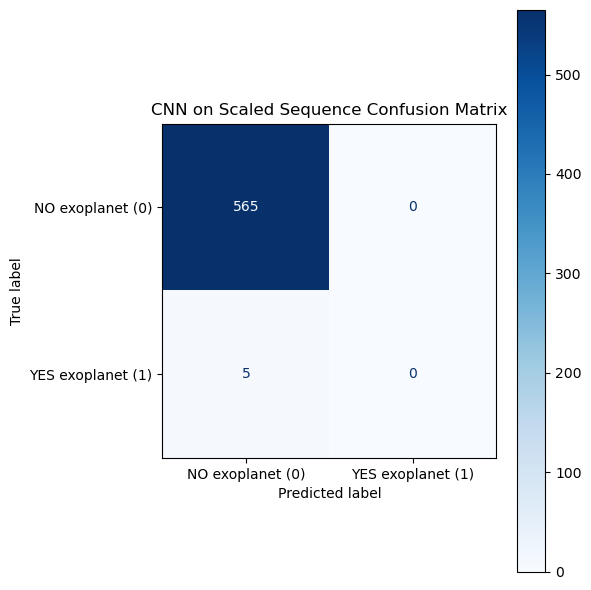


Script finished.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Core ML imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# PCA is removed as we are using the raw sequence
from imblearn.over_sampling import RandomOverSampler

# TensorFlow / Keras imports for CNN
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks

# --- Configuration ---
# Using relative paths assuming data is in the same directory as the script
# Or update these to absolute paths if needed
TRAIN_CSV_PATH = 'exoTrain.csv'
TEST_CSV_PATH = 'exoTest.csv'
RANDOM_STATE = 42
# PCA_COMPONENTS is removed
VALIDATION_SPLIT_SIZE = 0.2 # 20% of training data for validation
EPOCHS = 50 # Number of training epochs for the CNN (might need adjustment)
BATCH_SIZE = 64 # Batch size for CNN training

# --- Data Loading ---
def load_data(train_path, test_path):
    """Loads training and testing data from CSV files."""
    try:
        print(f"Loading training data from: {train_path}")
        df_train = pd.read_csv(train_path)
        print(f"Loading testing data from: {test_path}")
        df_test = pd.read_csv(test_path)
        print("Data loaded successfully.")
        # Store the number of flux features dynamically
        num_features = df_train.shape[1] - 1 # Subtract 1 for the 'LABEL' column
        print(f"Detected {num_features} flux features.")
        return df_train, df_test, num_features
    except FileNotFoundError:
        print(f"Error: One or both files not found. Please check paths:")
        print(f"- Train path: {train_path}")
        print(f"- Test path: {test_path}")
        return None, None, None
    except Exception as e:
        print(f"An error occurred during data loading: {e}")
        return None, None, None

# --- Data Preprocessing (CPU) ---
def preprocess_and_scale_cpu(df_train, df_test):
    """Separates features/labels, scales features, returns numpy arrays."""
    print("Preprocessing data (CPU steps)...")
    # Separate features (X) and labels (y)
    X_train_raw = df_train.drop('LABEL', axis=1)
    y_train_raw = df_train['LABEL']
    X_test_raw = df_test.drop('LABEL', axis=1)
    y_test_raw = df_test['LABEL']

    # Convert labels: 1 (no exoplanet) -> 0, 2 (exoplanet) -> 1
    y_train = (y_train_raw - 1).astype(int).values # Get as numpy array
    y_test = (y_test_raw - 1).astype(int).values # Get as numpy array

    print(f"Original training set shape: {X_train_raw.shape}")
    print(f"Original test set shape: {X_test_raw.shape}")
    print(f"Training labels distribution:\n{pd.Series(y_train).value_counts()}")
    print(f"Test labels distribution:\n{pd.Series(y_test).value_counts()}")

    # Scale features using StandardScaler (CPU)
    print("Scaling features using StandardScaler (CPU)...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_raw.values)
    X_test_scaled = scaler.transform(X_test_raw.values)

    print("CPU Preprocessing and Scaling complete.")
    # Return scaler and scaled data + labels
    return scaler, X_train_scaled, y_train, X_test_scaled, y_test

# --- Oversampling (CPU) ---
def oversample_cpu(X_train_processed, y_train):
    """Performs oversampling on the processed training data (CPU)."""
    print("Oversampling training data using RandomOverSampler (CPU)...")
    oversampler = RandomOverSampler(sampling_strategy='auto', random_state=RANDOM_STATE)
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_processed, y_train)
    print(f"Training data shape after oversampling: {X_train_resampled.shape}")
    print(f"Training labels distribution after oversampling:\n{pd.Series(y_train_resampled).value_counts()}")
    return X_train_resampled, y_train_resampled

# --- CNN Model Definition ---
def build_cnn_model(input_shape):
    """Builds a 1D CNN model using Keras for the raw sequence."""
    print("\n--- Building CNN Model for Raw Sequence ---")
    model = models.Sequential(name="Exoplanet_1D_CNN_on_Sequence")

    # Input Layer expects shape (sequence_length, channels=1)
    model.add(layers.Input(shape=input_shape))

    # Convolutional Block 1 - Adjusted kernel size for longer sequence
    model.add(layers.Conv1D(filters=64, kernel_size=7, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=3)) # Slightly larger pool size
    model.add(layers.Dropout(0.3)) # Increased dropout slightly

    # Convolutional Block 2
    model.add(layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=3))
    model.add(layers.Dropout(0.3))

    # Convolutional Block 3 (Optional: Add more depth for complex patterns)
    model.add(layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Dropout(0.3))


    # Flatten and Dense Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu')) # Increased dense layer size
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    # Output Layer
    model.add(layers.Dense(1, activation='sigmoid')) # Sigmoid for binary classification

    # Compile Model
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0005), # Potentially lower LR
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    print(model.summary())
    return model

# --- CNN Model Training ---
def train_cnn_model(model, X_train_reshaped, y_train_ovs, X_val_reshaped, y_val, epochs, batch_size):
    """Trains the compiled Keras CNN model."""
    print("\n--- Training CNN Model ---")

    # Callbacks for training
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

    start_time = time.time()
    history = model.fit(
        X_train_reshaped,
        y_train_ovs,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val_reshaped, y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    end_time = time.time()
    print(f"CNN Training completed in {end_time - start_time:.2f} seconds.")
    return history

# --- Plot Training History ---
def plot_training_history(history, model_name):
    """Plots accuracy and loss curves for training and validation sets."""
    print(f"\n--- Plotting Training History for {model_name} ---")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Accuracy
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{model_name} Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot Loss
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{model_name} Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# --- CNN Model Evaluation ---
def evaluate_cnn_model(model, X_test_reshaped, y_test, model_name="CNN Model"):
    """Evaluates the trained CNN model on the test set."""
    print(f"\n--- Evaluating {model_name} ---")

    # Evaluate loss and accuracy on test set
    loss, accuracy = model.evaluate(X_test_reshaped, y_test, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    # Predict probabilities and classes
    print("Predicting on test data...")
    start_time = time.time()
    y_pred_proba = model.predict(X_test_reshaped).flatten() # Flatten output
    y_pred = (y_pred_proba > 0.5).astype(int) # Threshold probabilities
    end_time = time.time()
    print(f"Prediction completed in {end_time - start_time:.2f} seconds.")

    # Print Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=["NO exoplanet (0)", "YES exoplanet (1)"]))

    # Plot Confusion Matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NO exoplanet (0)", "YES exoplanet (1)"])

    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f'{model_name} Confusion Matrix')
    plt.tight_layout()
    plt.show()


# --- Main Execution ---
if __name__ == "__main__":
    print("Starting Exoplanet Detection Script (CNN on Scaled Sequence)...")

    # 1. Load Data
    df_train, df_test, num_features = load_data(TRAIN_CSV_PATH, TEST_CSV_PATH)

    if df_train is not None and df_test is not None:
        # 2. Preprocess Data (Scale only)
        scaler, X_train_scaled, y_train, X_test_scaled, y_test = preprocess_and_scale_cpu(
            df_train, df_test
        )

        # 3. Split Training data for Validation (before oversampling)
        X_train_split, X_val, y_train_split, y_val = train_test_split(
            X_train_scaled, y_train,
            test_size=VALIDATION_SPLIT_SIZE,
            random_state=RANDOM_STATE,
            stratify=y_train # Ensure similar class distribution in train/val splits
        )
        print(f"\nSplit training data into {len(X_train_split)} for training, {len(X_val)} for validation.")

        # 4. Oversample the *training* split only
        X_train_ovs, y_train_ovs = oversample_cpu(X_train_split, y_train_split)

        # 5. Reshape Data for 1D CNN
        # Reshape to (num_samples, steps=num_features, channels=1)
        X_train_reshaped = X_train_ovs.reshape((X_train_ovs.shape[0], num_features, 1))
        X_val_reshaped = X_val.reshape((X_val.shape[0], num_features, 1))
        X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], num_features, 1))
        print(f"\nReshaped data for CNN input:")
        print(f"Training data shape: {X_train_reshaped.shape}")
        print(f"Validation data shape: {X_val_reshaped.shape}")
        print(f"Test data shape: {X_test_reshaped.shape}")

        # 6. Build CNN Model
        # Pass the sequence length (num_features) to the model builder
        cnn_model = build_cnn_model(input_shape=(num_features, 1))

        # 7. Train CNN Model
        history = train_cnn_model(
            cnn_model,
            X_train_reshaped, y_train_ovs,
            X_val_reshaped, y_val,
            epochs=EPOCHS, batch_size=BATCH_SIZE
        )

        # 8. Plot Training History
        plot_training_history(history, "CNN on Scaled Sequence")

        # 9. Evaluate CNN Model on Test Set
        evaluate_cnn_model(cnn_model, X_test_reshaped, y_test, model_name="CNN on Scaled Sequence")

        print("\nScript finished.")
    else:
        print("\nScript aborted due to data loading errors.")
